Here we investigate the measure of coherence for synthetic data sets.

In [282]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

from sklearn.model_selection import train_test_split

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [283]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

We first consider when our dataset contains just a single data point. Therefore, according to the theory all examples are perfectly coherent and thus $\alpha_m=1$ which implies that $\alpha_m/\alpha_m^\perp=m$.

In [284]:
input_size = 2
hidden_size = 2048
num_classes = 2
num_epochs = 250
batch_size = 50
learning_rate = 0.01

In [285]:
X=[]
y=[]
for n in range(1000):
    X.append([0,0])
    y.append(0)

X=torch.from_numpy(np.array(X)).float()
y=torch.from_numpy(np.array(y)).float()

In [286]:
# Train the model

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for batchX, batchY in next_batch(X, y, batch_size):
        outputs = model(batchX)
        loss = criterion(outputs, batchY.long())
        optimizer.zero_grad()
        loss.backward()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        batch_gradient+=model.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        batch_gradient+=model.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1

        optimizer.step()

        
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot

    perexample_coherence=batchwise_coherence/(batch_size-(batch_size-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*len(X)

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for batchX, batchY in loader:
            outputs = model(batchX)
            total += batchY.size(0)
            correct += (outputs.max(1)[1] == batchY).sum().item()
        return correct/total

loss_list=[]
accuracy_list=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    loss_list.append(trainloss)
    alpha_list.append(alpha)
    accuracy_list.append(accuracy(next_batch(X, y, batch_size)))
    epoch_list.append(epoch)
    print('Epoch: {} Loss: {:.3f} Accuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,loss_list[-1],accuracy_list[-1],alpha_list[-1]))

Epoch: 1 Loss: 0.320 Accuracy: 1.000 Coherence: 370.325
Epoch: 2 Loss: 0.130 Accuracy: 1.000 Coherence: 266.326
Epoch: 3 Loss: 0.079 Accuracy: 1.000 Coherence: 514.494
Epoch: 4 Loss: 0.058 Accuracy: 1.000 Coherence: 731.293
Epoch: 5 Loss: 0.046 Accuracy: 1.000 Coherence: 836.179
Epoch: 6 Loss: 0.039 Accuracy: 1.000 Coherence: 888.353
Epoch: 7 Loss: 0.033 Accuracy: 1.000 Coherence: 918.373
Epoch: 8 Loss: 0.029 Accuracy: 1.000 Coherence: 937.542
Epoch: 9 Loss: 0.026 Accuracy: 1.000 Coherence: 950.622
Epoch: 10 Loss: 0.024 Accuracy: 1.000 Coherence: 959.967
Epoch: 11 Loss: 0.021 Accuracy: 1.000 Coherence: 966.882
Epoch: 12 Loss: 0.020 Accuracy: 1.000 Coherence: 972.145
Epoch: 13 Loss: 0.018 Accuracy: 1.000 Coherence: 976.244
Epoch: 14 Loss: 0.017 Accuracy: 1.000 Coherence: 979.498
Epoch: 15 Loss: 0.016 Accuracy: 1.000 Coherence: 982.127
Epoch: 16 Loss: 0.015 Accuracy: 1.000 Coherence: 984.278
Epoch: 17 Loss: 0.014 Accuracy: 1.000 Coherence: 986.064
Epoch: 18 Loss: 0.013 Accuracy: 1.000 Co

Text(0.5, 1.0, 'Coherence Against Loss')

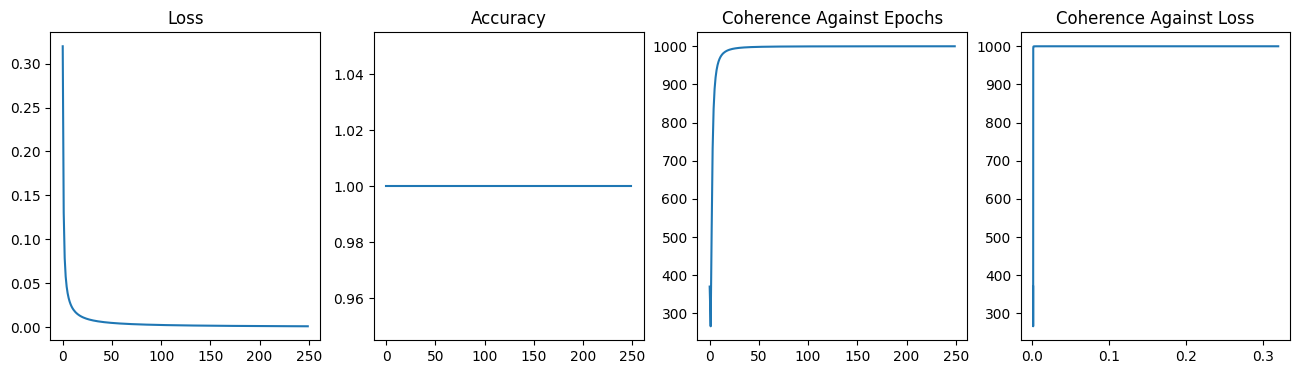

In [287]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(epoch_list, loss_list)
axs[0].set_title('Loss')
axs[1].plot(epoch_list, accuracy_list)
axs[1].set_title('Accuracy')
axs[2].plot(epoch_list, alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].plot(np.flip(loss_list), alpha_list)
axs[3].set_title('Coherence Against Loss')

In the case where are model achieves perfect accuracy and (almost) zero loss, we expect that examples no longer help learn about other examples as there is no more too learn. Hence, we expect that coherence is (close to) to zero, $\alpha_m/\alpha_m^\perp=0$. 

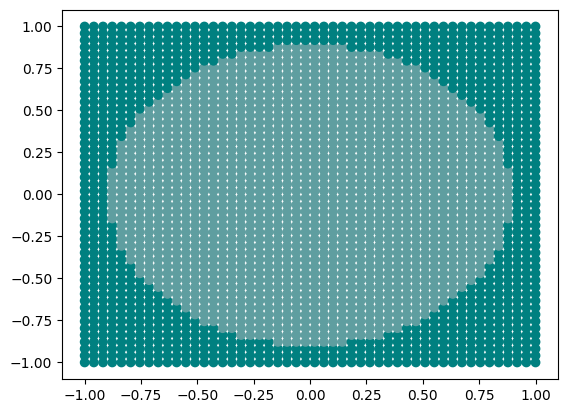

In [288]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if x[0]**2+x[1]**2<np.sqrt(2/np.pi) else 0
y=np.array([encode_inputs(x) for x in X])

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

colors=np.full(len(y), 'cadetblue')
colors[y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [289]:
# Train the model

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for batchX, batchY in next_batch(X, y, batch_size):
        outputs = model(batchX)
        loss = criterion(outputs, batchY.long())
        optimizer.zero_grad()
        loss.backward()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        batch_gradient+=model.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        batch_gradient+=model.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1

        optimizer.step()

        
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot

    perexample_coherence=batchwise_coherence/(batch_size-(batch_size-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*len(X)

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for batchX, batchY in loader:
            outputs = model(batchX)
            total += batchY.size(0)
            correct += (outputs.max(1)[1] == batchY).sum().item()
        return correct/total

loss_list=[]
accuracy_list=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    loss_list.append(trainloss)
    alpha_list.append(alpha)
    accuracy_list.append(accuracy(next_batch(X, y, batch_size)))
    epoch_list.append(epoch)
    print('Epoch: {} Loss: {:.3f} Accuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,loss_list[-1],accuracy_list[-1],alpha_list[-1]))

Epoch: 1 Loss: 1.092 Accuracy: 0.603 Coherence: 2.680
Epoch: 2 Loss: 0.849 Accuracy: 0.604 Coherence: 1.424
Epoch: 3 Loss: 0.671 Accuracy: 0.670 Coherence: 1.109
Epoch: 4 Loss: 0.549 Accuracy: 0.716 Coherence: 1.012
Epoch: 5 Loss: 0.447 Accuracy: 0.734 Coherence: 0.955
Epoch: 6 Loss: 0.367 Accuracy: 0.747 Coherence: 0.905
Epoch: 7 Loss: 0.310 Accuracy: 0.778 Coherence: 0.859
Epoch: 8 Loss: 0.272 Accuracy: 0.809 Coherence: 0.812
Epoch: 9 Loss: 0.247 Accuracy: 0.833 Coherence: 0.762
Epoch: 10 Loss: 0.229 Accuracy: 0.853 Coherence: 0.701
Epoch: 11 Loss: 0.215 Accuracy: 0.867 Coherence: 0.641
Epoch: 12 Loss: 0.203 Accuracy: 0.882 Coherence: 0.585
Epoch: 13 Loss: 0.191 Accuracy: 0.894 Coherence: 0.537
Epoch: 14 Loss: 0.181 Accuracy: 0.907 Coherence: 0.499
Epoch: 15 Loss: 0.171 Accuracy: 0.920 Coherence: 0.469
Epoch: 16 Loss: 0.161 Accuracy: 0.928 Coherence: 0.439
Epoch: 17 Loss: 0.151 Accuracy: 0.933 Coherence: 0.413
Epoch: 18 Loss: 0.142 Accuracy: 0.942 Coherence: 0.389
Epoch: 19 Loss: 0.1

Text(0.5, 1.0, 'Coherence Against Loss')

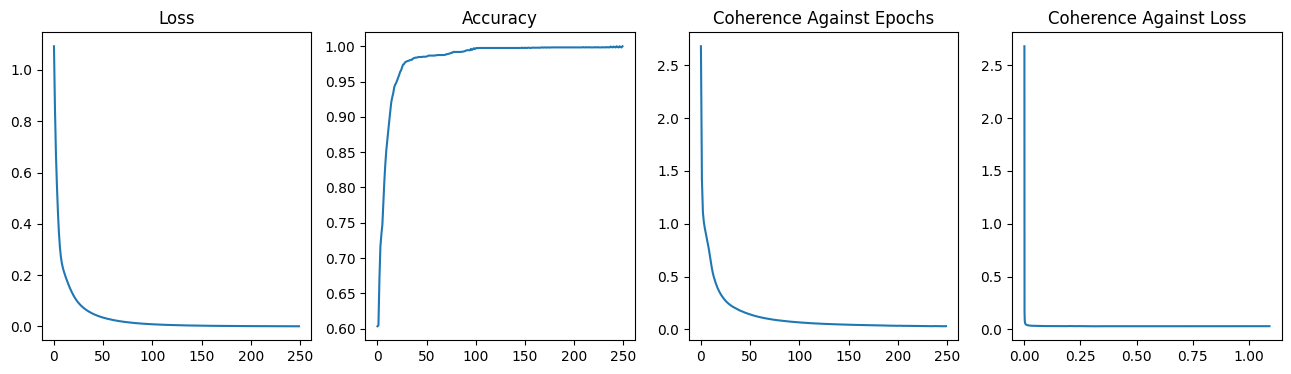

In [290]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(epoch_list, loss_list)
axs[0].set_title('Loss')
axs[1].plot(epoch_list, accuracy_list)
axs[1].set_title('Accuracy')
axs[2].plot(epoch_list, alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].plot(np.flip(loss_list), alpha_list)
axs[3].set_title('Coherence Against Loss')

In [358]:
RES=3
X=[]
y=[]
for x_1 in range(3):
    for x_2 in range(3):
        for n in range(100):
            X.append([x_1,x_2])
            y.append(3*x_1+x_2)
X=np.array(X)
y=np.array(y)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()


In [359]:
input_size = 2
hidden_size = 2048
num_classes = 9
batch_size = 100

In [360]:
# Train the model

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for batchX, batchY in next_batch(X, y, 1):
        outputs = model(batchX)
        loss = criterion(outputs, batchY.long())
        optimizer.zero_grad()
        loss.backward()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        batch_gradient+=model.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        batch_gradient+=model.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient*len(batchX)
        expected_dot+=dot(batch_gradient,batch_gradient)*len(batchX)
        counter+=1
        
        optimizer.step()

    expected_dot=expected_dot/len(X)
    expected_gradient=expected_gradient/len(X)
    batchwise_coherence=dot(expected_gradient,expected_gradient)/(expected_dot)

    perexample_coherence=batchwise_coherence/(batch_size-(batch_size-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*len(X)

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for batchX, batchY in loader:
            outputs = model(batchX)
            total += batchY.size(0)
            correct += (outputs.max(1)[1] == batchY).sum().item()
        return correct/total

loss_list=[]
accuracy_list=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    loss_list.append(trainloss)
    alpha_list.append(alpha)
    accuracy_list.append(accuracy(next_batch(X, y, batch_size)))
    epoch_list.append(epoch)
    print('Epoch: {} Loss: {:.3f} Accuracy: {:.3f} Coherence: {}'.format(epoch+1,loss_list[-1],accuracy_list[-1],alpha_list[-1]))

Epoch: 1 Loss: 0.027 Accuracy: 0.111 Coherence: 0.14256398648592075
Epoch: 2 Loss: 0.017 Accuracy: 0.222 Coherence: 0.0669413210960817
Epoch: 3 Loss: 0.013 Accuracy: 0.222 Coherence: 0.045088923945968216
Epoch: 4 Loss: 0.011 Accuracy: 0.333 Coherence: 0.03146351828567284
Epoch: 5 Loss: 0.010 Accuracy: 0.333 Coherence: 0.0225866042230797
Epoch: 6 Loss: 0.009 Accuracy: 0.556 Coherence: 0.01744105779304462
Epoch: 7 Loss: 0.008 Accuracy: 0.667 Coherence: 0.0147268078873313
Epoch: 8 Loss: 0.008 Accuracy: 0.778 Coherence: 0.01335783280874955
Epoch: 9 Loss: 0.007 Accuracy: 0.778 Coherence: 0.012796297689641238
Epoch: 10 Loss: 0.007 Accuracy: 1.000 Coherence: 0.01274825140336403
Epoch: 11 Loss: 0.006 Accuracy: 1.000 Coherence: 0.013076405957663106
Epoch: 12 Loss: 0.006 Accuracy: 1.000 Coherence: 0.013777211081276426
Epoch: 13 Loss: 0.006 Accuracy: 1.000 Coherence: 0.014812215676489382
Epoch: 14 Loss: 0.006 Accuracy: 1.000 Coherence: 0.016158649072186157
Epoch: 15 Loss: 0.005 Accuracy: 1.000 Co